https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew
    
https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p


With the surge in popularity of ridesharing apps such as Uber and Lyft over traditional taxi services, consumers trade convienince for a general lack of tranparency regarding prices. Ridesharing services often seem like a better deal than taxi services, but prices fluctuate drastically depending on demand and service choice. Companies such as Bellhop seek to make it easy for users to compare services, and can help users make choices between ridesharing and taxis in real time. I want to find a quantitive answer to the question of weather a given ridesharing price is fair given averages across services and taxi service. More specifically, given ride endpoints and estimated ride time, can we predict what the ridesharing price should be?

My proposal centers around two datasets: the recently released 'Transportation Network Providers' (TNP) data and 'Taxi-Trips' data from the city of Chicago government website. Analysis will focus on the most recent data (2018 in for the TNP and 2017 for the taxi trips). A project plan is listed below. Items 1-2 have been completed for preliminary analysis, while items 2-_ would be part of a full project.

1. Exploratory analysis of TNP dataset
    - What is the distribution of prices, how directly do they correlate with trip time and location?
    - What data features actually matter for price? 
    - Are there price/usage trends?
2. Exploratory analysis of Taxi dataset
    - Same as above, these are very similar looking datasets
3. Are there any general trends to note between the two datasets... eg.. Taxi is almost always better?
4. Create predictive models for the price for each of the above. Test/train split before going any further. (using some ML eg.. random forest)
5. Provide a web interface where a user can give their route information in chicago. We tell them an estimated taxi/TNP price and they can compare their offers with that. 


One issue: the taxi dataset ends in 2017. For now, we will compare prices over two months from both datasets. That is Jun and July 2017 in the taxi data and Nov. and Dec 2018 for the TNP dataset. At some point we can also see if the choice of the time window (in eg... winter) for the taxi dataset affects the model strongly.

   

In [1]:
import pandas as pd
from sodapy import Socrata
import matplotlib.pyplot as plt
import numpy as np

In [2]:
query = ("https://data.cityofchicago.org/resource/m6dm-c72p.json")
raw_data = pd.read_json(query)

In [3]:
uname = 'bobmeetsabe@gmail.com'
APPTOK = 'leL1qsHufdxYHXCdRVR3FtdgN'

client = Socrata("data.cityofchicago.org",
                  APPTOK,
                  username=uname,
                  password="SsthSrZ65XFMW3e")

In [4]:
#results = client.get("m6dm-c72p", limit=int(1e6), order="trip_start_timestamp DESC")

In [5]:
#tnp = pd.DataFrame.from_records(results)

In [6]:
import random
p = 0.005  # .5% of the lines

tnp = pd.read_csv(
         'Transportation_Network_Providers_-_Trips.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)


In [7]:
tnp.columns = tnp.columns.str.replace(' ', '_') # for dot notation
tnp.head()

,Trip_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,Fare,...,Additional_Charges,Trip_Total,Shared_Trip_Authorized,Trips_Pooled,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid_Location
0,2547eb1ce54b4ba24cfe8c578af538f17864c074,11/01/2018 11:00:00 PM,11/01/2018 11:15:00 PM,751.0,4.9,NaN,NaN,72.0,NaN,10.0,...,2.50,12.50,False,1,41.713149,-87.675075,POINT (-87.67507531240001 41.713148612),NaN,NaN,NaN
1,7ee1247809334c53fa02513865bfc4a4b773054c,11/01/2018 07:30:00 AM,11/01/2018 08:15:00 AM,2852.0,19.8,1.703198e+10,NaN,56.0,NaN,30.0,...,8.55,41.55,False,1,41.785999,-87.750934,POINT (-87.7509342894 41.785998518),NaN,NaN,NaN
2,e8424be674698022d3cc2fe59cd98968c215fdc9,11/01/2018 05:15:00 PM,11/01/2018 05:30:00 PM,1089.0,3.5,NaN,NaN,NaN,10.0,7.5,...,2.50,10.00,True,1,NaN,NaN,NaN,41.985015,-87.804532,POINT (-87.8045320063 41.9850151008)
3,bf544dafba30b05dde45264f5daa92166b79b816,11/01/2018 12:30:00 AM,11/01/2018 01:00:00 AM,1877.0,30.7,1.703198e+10,NaN,76.0,NaN,35.0,...,9.30,49.30,False,1,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),NaN,NaN,NaN
4,de8902cc23e3849e2b144103ad4bdce7d49d4d2a,11/01/2018 06:15:00 AM,11/01/2018 06:45:00 AM,1900.0,16.6,NaN,1.703198e+10,NaN,76.0,25.0,...,8.43,33.43,False,1,NaN,NaN,NaN,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201)


Dropping a lot of extra categorical and other variables for now, may add them later and see if they can help fit performance.

In [8]:
currently_unused_col = ['Trip_ID','Trip_End_Timestamp','Pickup_Census_Tract', 'Dropoff_Census_Tract','Pickup_Community_Area', 
                        'Dropoff_Community_Area','Tip','Additional_Charges', 'Trip_Total', 'Shared_Trip_Authorized','Trips_Pooled']
tnp.drop(currently_unused_col, axis=1, inplace=True)

In [9]:
tnp['Trip_Start_Timestamp'] = pd.to_datetime(tnp['Trip_Start_Timestamp'],infer_datetime_format = True)

In [10]:
tnp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87258 entries, 0 to 87257
Data columns (total 10 columns):
Trip_Start_Timestamp          87258 non-null datetime64[ns]
Trip_Seconds                  87244 non-null float64
Trip_Miles                    87258 non-null float64
Fare                          87258 non-null float64
Pickup_Centroid_Latitude      82068 non-null float64
Pickup_Centroid_Longitude     82068 non-null float64
Pickup_Centroid_Location      82068 non-null object
Dropoff_Centroid_Latitude     81463 non-null float64
Dropoff_Centroid_Longitude    81463 non-null float64
Dropoff_Centroid_Location     81463 non-null object
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 6.7+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1db0e2e860>,
      dtype=object)

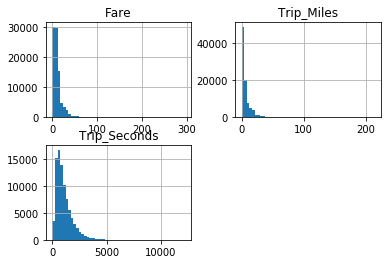

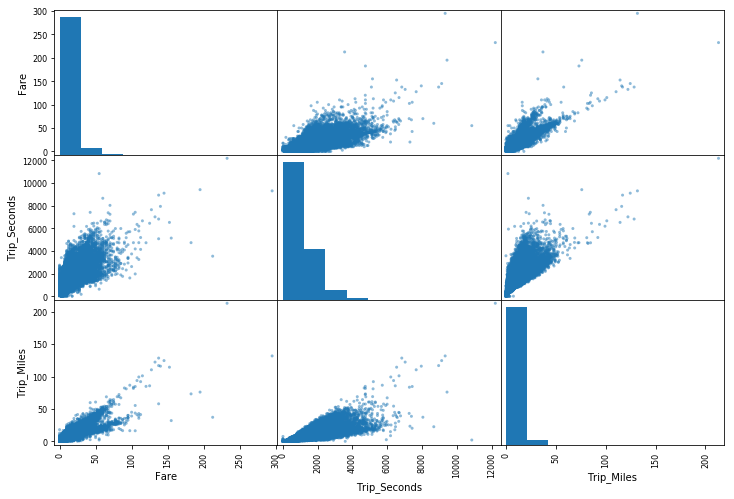

In [11]:
from pandas.plotting import scatter_matrix

attributes = ['Fare','Trip_Seconds','Trip_Miles']

tnp[['Fare','Trip_Seconds','Trip_Miles']].hist(bins = 50)#, figsize = (20,15))
scatter_matrix(tnp[attributes],figsize = (12,8))

The fare is, as expected, heavily correlated with the duration and the length of the ride. To perform better for larger fares, we'll use stratified sampling on the trip_miles.

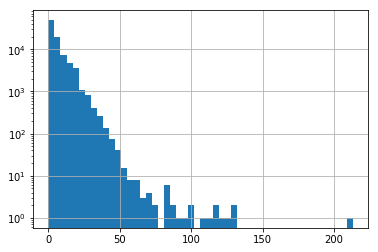

In [12]:
tnp.Trip_Miles.hist(bins = 50, log = True)
# Drop trips with no distance attribute
tnp.drop(tnp[tnp.Trip_Miles <=0].index, inplace=True)

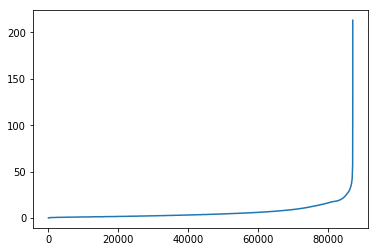

In [13]:
# bin the trip length
plt.plot(tnp.Trip_Miles.sort_values().values)

In [14]:
# drop unusually large or small fares
tnp.drop(tnp[((tnp.Fare > 200) | (tnp.Fare <= 0))].index,inplace = True)

In [15]:
cat_size = 3.
max_bin_dist = 30
tnp["distance_cat"]= np.ceil(tnp["Trip_Miles"]/cat_size) 

# lump all rides above 30 nules into category 
tnp["distance_cat"].where(tnp["distance_cat"]<max_bin_dist/cat_size,max_bin_dist/cat_size,inplace=True)

In [16]:
tnp["distance_cat"].value_counts()

1.0     37174
2.0     21754
3.0      9995
4.0      5160
5.0      3757
6.0      3393
7.0      2021
10.0     1467
8.0       881
9.0       639
Name: distance_cat, dtype: int64

In [17]:
tnp.count()

Trip_Start_Timestamp          86241
Trip_Seconds                  86227
Trip_Miles                    86241
Fare                          86241
Pickup_Centroid_Latitude      81058
Pickup_Centroid_Longitude     81058
Pickup_Centroid_Location      81058
Dropoff_Centroid_Latitude     80458
Dropoff_Centroid_Longitude    80458
Dropoff_Centroid_Location     80458
distance_cat                  86241
dtype: int64

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state = 1337)
for train_index, test_index in split.split(tnp,tnp["distance_cat"]):
    strat_train_set = tnp.iloc[train_index]
    strat_test_set = tnp.iloc[test_index]

In [19]:
strat_test_set.count()

Trip_Start_Timestamp          17249
Trip_Seconds                  17248
Trip_Miles                    17249
Fare                          17249
Pickup_Centroid_Latitude      16211
Pickup_Centroid_Longitude     16211
Pickup_Centroid_Location      16211
Dropoff_Centroid_Latitude     16130
Dropoff_Centroid_Longitude    16130
Dropoff_Centroid_Location     16130
distance_cat                  17249
dtype: int64

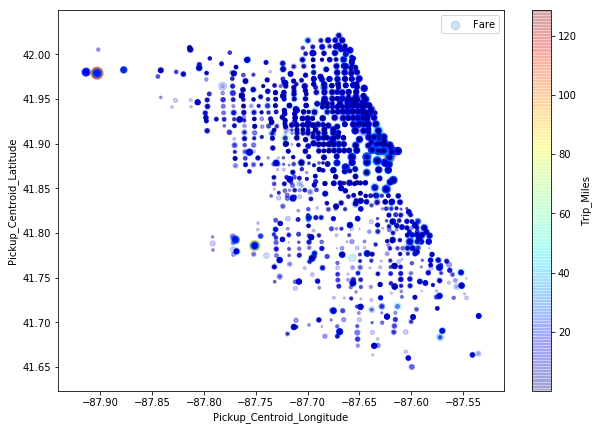

In [20]:
strat_train_set.plot(kind = "Scatter", x = "Pickup_Centroid_Longitude", y = "Pickup_Centroid_Latitude", alpha = 0.2,
            s = strat_train_set["Fare"], label = "Fare", figsize = (10,7),
            c = "Trip_Miles", cmap = plt.get_cmap('jet'),colorbar = True, sharex=False
)
plt.legend()
plt.show()

In [21]:
strat_train_set.columns

Index(['Trip_Start_Timestamp', 'Trip_Seconds', 'Trip_Miles', 'Fare',
       'Pickup_Centroid_Latitude', 'Pickup_Centroid_Longitude',
       'Pickup_Centroid_Location', 'Dropoff_Centroid_Latitude',
       'Dropoff_Centroid_Longitude', 'Dropoff_Centroid_Location',
       'distance_cat'],
      dtype='object')

### Model Fitting
Going to drop N/A columns for this first pass.

In [22]:
strat_train_set.dropna(inplace = True)
fare_labels = strat_train_set["Fare"].copy()
ride_features = strat_train_set.drop("Fare", axis = 1)
ride_features[ride_features.isnull().any(axis=1)].head() # Incomplete rows
# specialize to the hour for timestaps:
ride_features['Trip_Start_Timestamp'] = ride_features.Trip_Start_Timestamp.dt.hour
ride_features.drop(["Pickup_Centroid_Location","Dropoff_Centroid_Location"], axis = 1, inplace = True)

/home/isaac/anaconda3/envs/skstack/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
print(ride_features.count(),fare_labels.count())

Trip_Start_Timestamp          60209
Trip_Seconds                  60209
Trip_Miles                    60209
Pickup_Centroid_Latitude      60209
Pickup_Centroid_Longitude     60209
Dropoff_Centroid_Latitude     60209
Dropoff_Centroid_Longitude    60209
distance_cat                  60209
dtype: int64 60209


In [24]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(ride_features,fare_labels)

# quick test
some_data = ride_features.iloc[:10]
some_labels = fare_labels.iloc[:10]
print("Predictions: ",lin_reg.predict(some_data))
print("Labels: ",list(some_labels))

# Linear underfitting
from sklearn.metrics import mean_squared_error
fare_predictions = lin_reg.predict(ride_features)
lin_mse = mean_squared_error(fare_labels, fare_predictions)
print("RMSE: ", np.sqrt(lin_mse))

Predictions:  [10.46158787  4.19452493  9.4400995   7.57727505 22.23235813 18.67960476
 15.21355828  3.72552476  3.20156198  6.79873675]
Labels:  [2.5, 2.5, 10.0, 10.0, 20.0, 22.5, 5.0, 2.5, 2.5, 5.0]
RMSE:  3.683722672928641


In [25]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, ride_features, fare_labels,
                             scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [3.65789304 3.51808956 3.78473554 3.74978551 3.70776579]
Mean: 3.6836538898502673
Standard deviation: 0.09300262701896343


### Taxi dataset

In [26]:
p = 0.4  # taxi usage is significantly smaller
taxi = pd.read_csv(
         'Taxi_Trips.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)

In [27]:
taxi.count()

Trip ID                       807105
Taxi ID                       806432
Trip Start Timestamp          807105
Trip End Timestamp            807062
Trip Seconds                  807044
Trip Miles                    807098
Pickup Census Tract           513747
Dropoff Census Tract          509749
Pickup Community Area         747525
Dropoff Community Area        729668
Fare                          807101
Tips                          807101
Tolls                         807101
Extras                        807101
Trip Total                    807101
Payment Type                  807105
Company                       483640
Pickup Centroid Latitude      747532
Pickup Centroid Longitude     747532
Pickup Centroid Location      747532
Dropoff Centroid Latitude     731289
Dropoff Centroid Longitude    731289
Dropoff Centroid  Location    731289
dtype: int64

In [28]:
taxi.columns = taxi.columns.str.replace(' ', '_') # for dot notation

currently_unused_col = ['Trip_ID','Taxi_ID','Trip_End_Timestamp','Pickup_Census_Tract', 'Dropoff_Census_Tract','Pickup_Community_Area', 
                        'Dropoff_Community_Area','Tips','Tolls','Extras','Trip_Total','Payment_Type','Company',
                       'Pickup_Centroid_Location', 'Dropoff_Centroid__Location']

taxi.drop(currently_unused_col, axis=1, inplace=True)

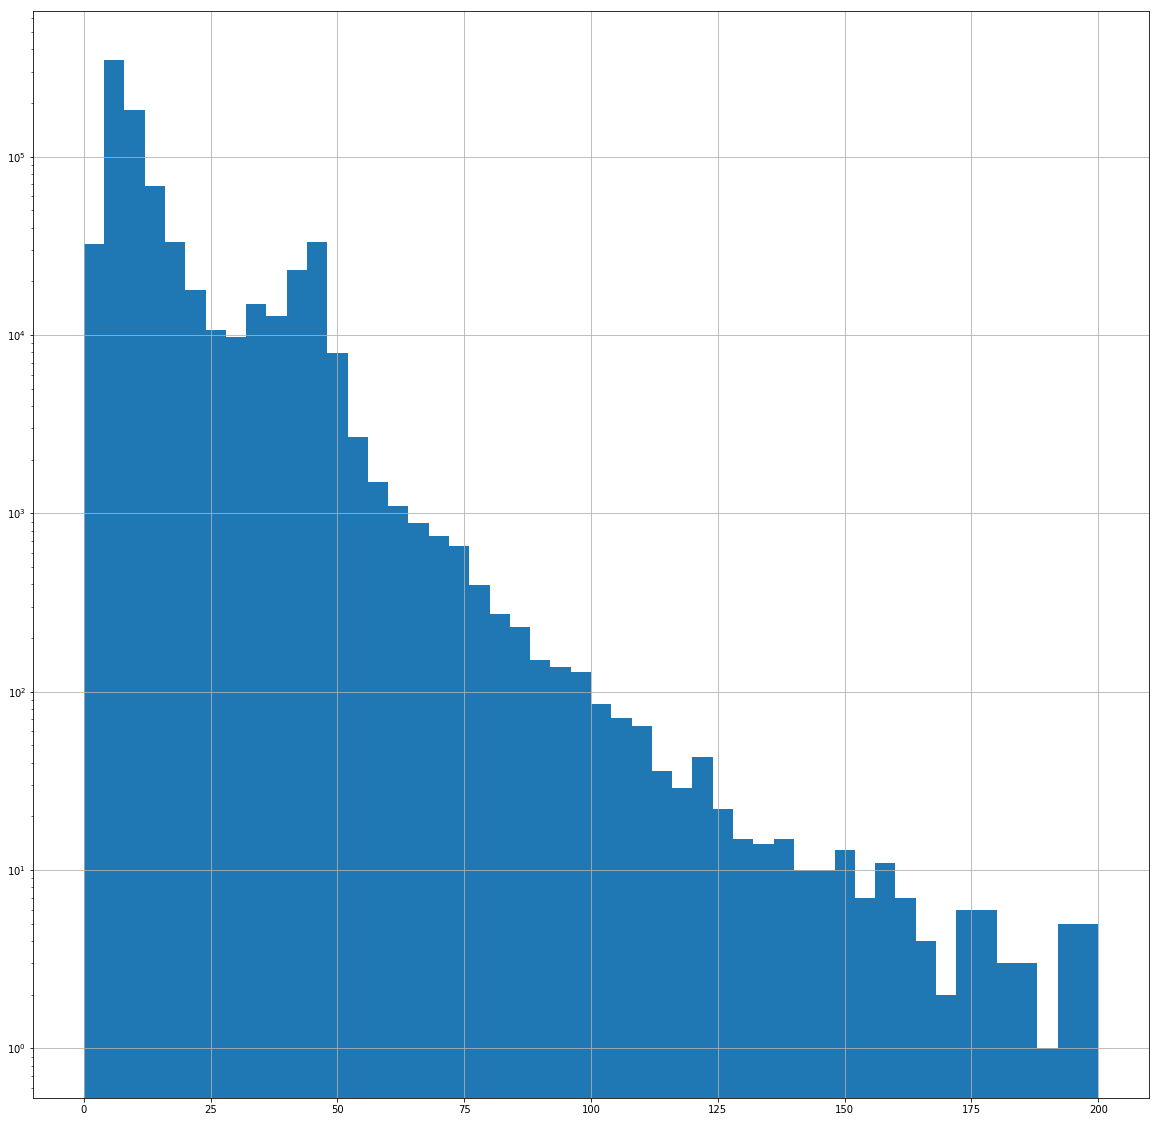

In [29]:
# there are some exceedingly large fares, lets drop them along with zero fees
taxi.drop(taxi[((taxi.Fare > 200) | (taxi.Fare <= 0))].index,axis = 0, inplace = True)
taxi.head()
taxi.Fare.hist(bins = 50, figsize = (20,20),log = True)

In [30]:
taxi.dtypes
taxi['Trip_Start_Timestamp'] = pd.to_datetime(taxi['Trip_Start_Timestamp'],infer_datetime_format = True)

In [31]:
cat_size = 3.
max_bin_dist = 30
taxi["distance_cat"]= np.ceil(taxi["Trip_Miles"]/cat_size) 

# lump all rides above 30 nules into category 
taxi["distance_cat"].where(taxi["distance_cat"]<max_bin_dist/cat_size,max_bin_dist/cat_size,inplace=True)

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state = 1337)
for train_index, test_index in split.split(tnp,tnp["distance_cat"]):
    strat_train_set = taxi.iloc[train_index]
    strat_test_set = taxi.iloc[test_index]

In [32]:
fare_labels_t = strat_train_set.dropna()["Fare"].copy()
ride_features_t = strat_train_set.drop("Fare", axis = 1)
ride_features_t[ride_features_t.isnull().any(axis=1)].head() # Incomplete rows
ride_features_t.dropna(inplace = True)
# specialize to the hour for timestaps:
ride_features_t['Trip_Start_Timestamp'] = ride_features_t.Trip_Start_Timestamp.dt.hour


In [33]:
ride_features_t.count()

Trip_Start_Timestamp          62112
Trip_Seconds                  62112
Trip_Miles                    62112
Pickup_Centroid_Latitude      62112
Pickup_Centroid_Longitude     62112
Dropoff_Centroid_Latitude     62112
Dropoff_Centroid_Longitude    62112
distance_cat                  62112
dtype: int64

In [34]:
lin_reg_t = LinearRegression()
lin_reg_t.fit(ride_features_t,fare_labels_t)

# quick test
some_data = ride_features.iloc[:10]
some_labels = fare_labels.iloc[:10]
print("Predictions: ",lin_reg.predict(some_data))
print("Labels: ",list(some_labels))

# Linear underfitting
fare_predictions_t = lin_reg_t.predict(ride_features_t)
lin_mse = mean_squared_error(fare_labels_t, fare_predictions_t)
print("RMSE: ", np.sqrt(lin_mse))

Predictions:  [10.46158787  4.19452493  9.4400995   7.57727505 22.23235813 18.67960476
 15.21355828  3.72552476  3.20156198  6.79873675]
Labels:  [2.5, 2.5, 10.0, 10.0, 20.0, 22.5, 5.0, 2.5, 2.5, 5.0]
RMSE:  5.111541725400671


In [76]:
taxi_estimate_on_ridesare = lin_reg_t.predict(ride_features)
rideshare_estimate_on_taxi = lin_reg.predict(ride_features_t)

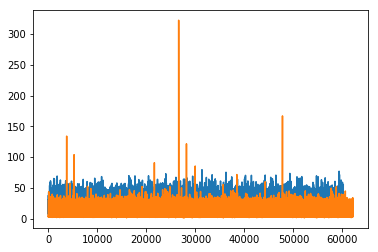

In [79]:
plt.plot(taxi_estimate_on_ridesare)
plt.plot(rideshare_estimate_on_taxi)

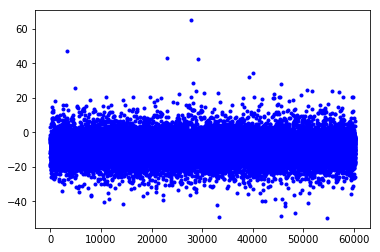

In [37]:
plt.plot(fare_labels.values-taxi_estimate_on_ridesare, 'b.')
#plt.plot(taxi_estimate_on_ridesare)

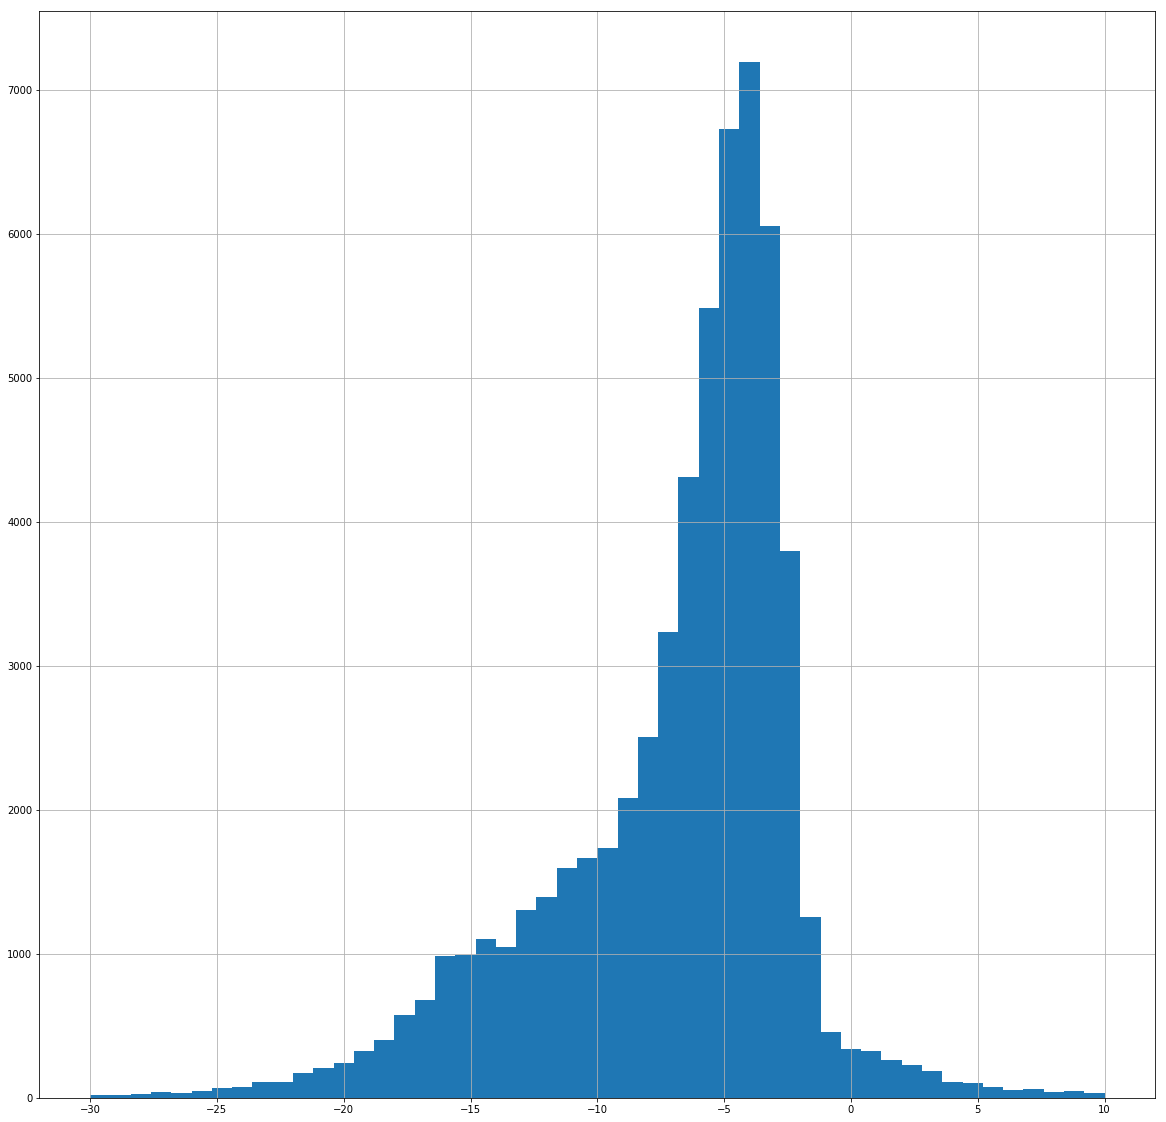

In [90]:
((fare_labels-taxi_estimate_on_ridesare)).hist(bins = 50, figsize = (20,20),range=[-30,10])

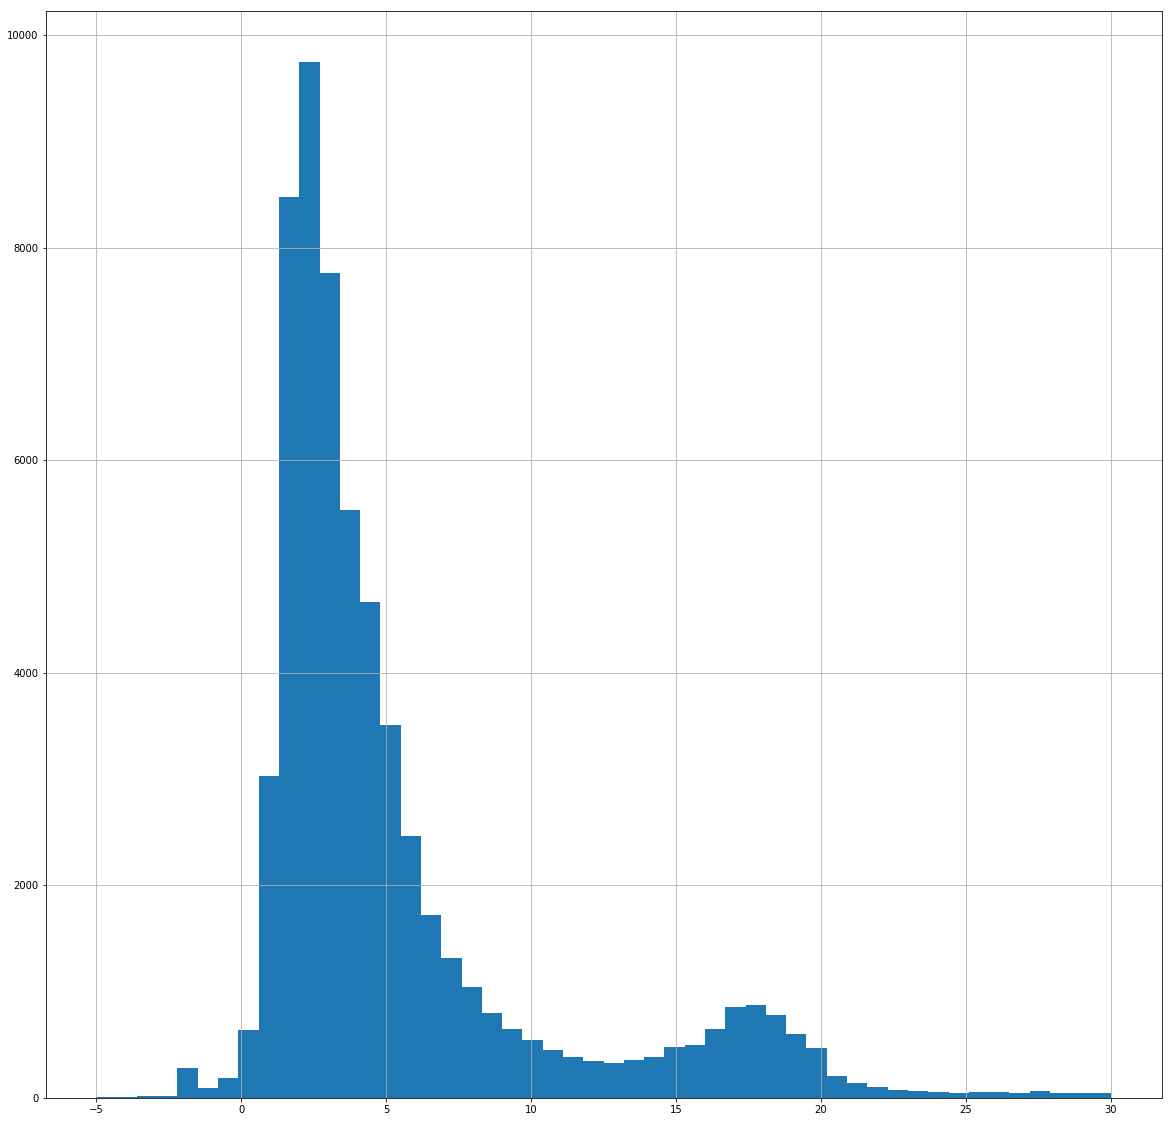

In [86]:
((fare_labels_t-rideshare_estimate_on_taxi)).hist(bins = 50, figsize = (20,20),range=[-5,30])

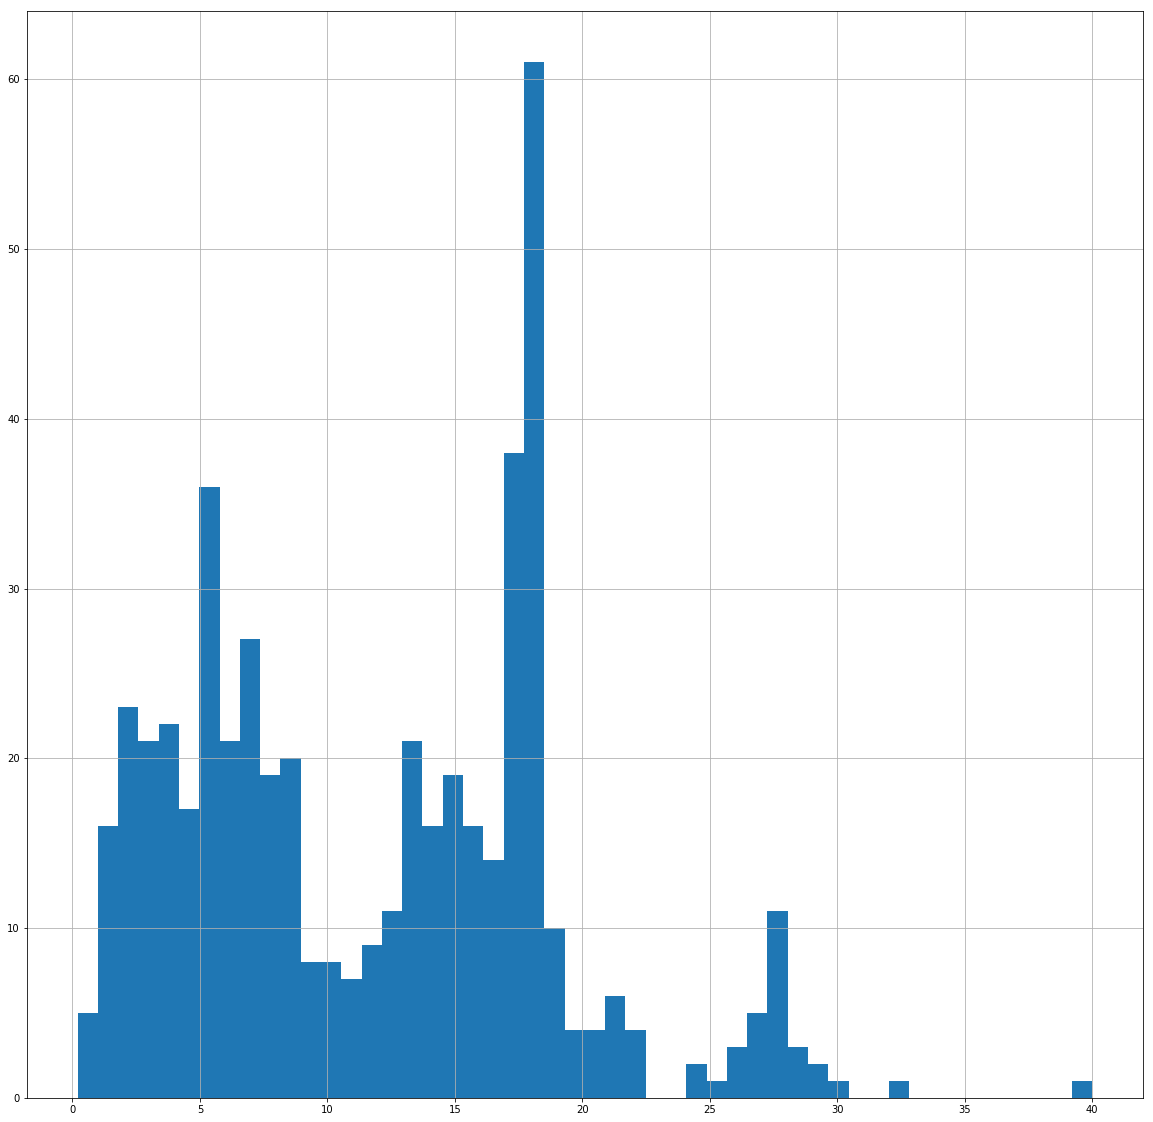

In [39]:
ride_features[(fare_labels-taxi_estimate_on_ridesare) >5].Trip_Miles.hist(bins = 50, figsize = (20,20))

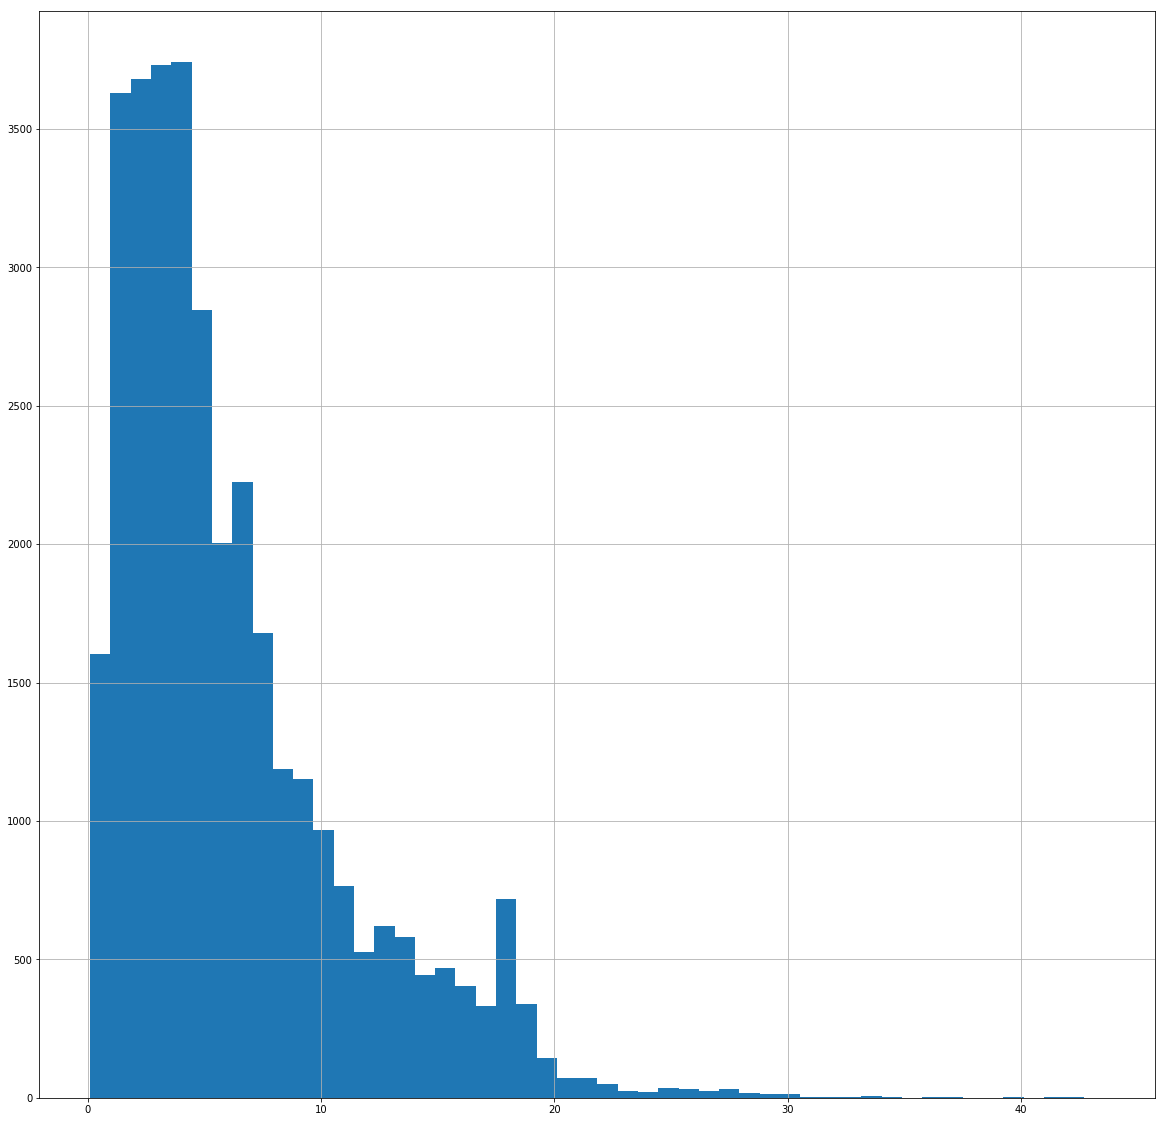

In [40]:
ride_features[(fare_labels-taxi_estimate_on_ridesare) <-5].Trip_Miles.hist(bins = 50, figsize = (20,20))

In [42]:
good_taxi_rides = ride_features[(fare_labels-taxi_estimate_on_ridesare) >5]
good_tnp_rides = ride_features[(fare_labels-taxi_estimate_on_ridesare) <-5]

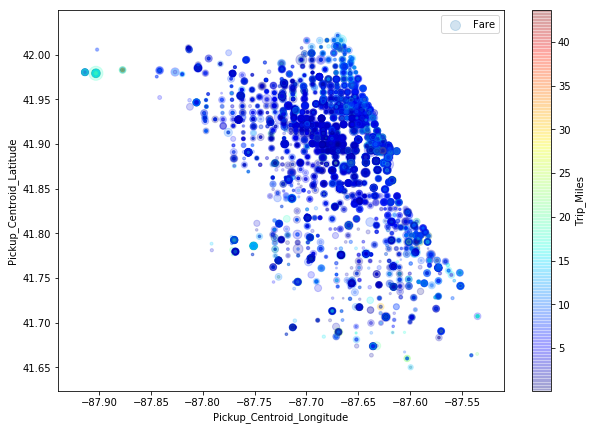

In [43]:
good_tnp_rides.plot(kind = "Scatter", x = "Pickup_Centroid_Longitude", y = "Pickup_Centroid_Latitude", alpha = 0.2,
            s = strat_train_set["Fare"], label = "Fare", figsize = (10,7),
            c = "Trip_Miles", cmap = plt.get_cmap('jet'),colorbar = True, sharex=False
)
plt.legend()
plt.show()

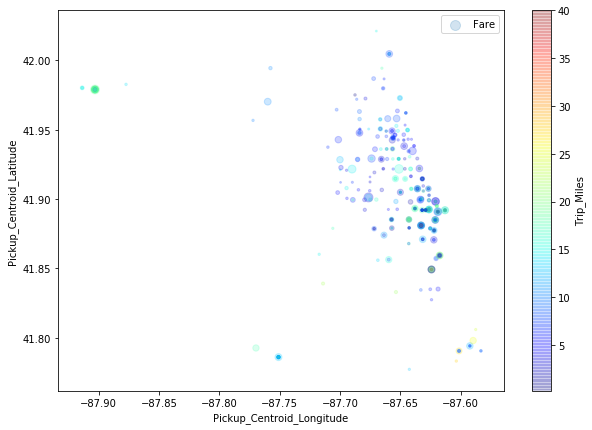

In [44]:
good_taxi_rides.plot(kind = "Scatter", x = "Pickup_Centroid_Longitude", y = "Pickup_Centroid_Latitude", alpha = 0.2,
            s = strat_train_set["Fare"], label = "Fare", figsize = (10,7),
            c = "Trip_Miles", cmap = plt.get_cmap('jet'),colorbar = True, sharex=False
)
plt.legend()
plt.show()

In [45]:
play = ride_features.copy()

In [65]:
play["cost_diff"] = np.ceil(10*(fare_labels-taxi_estimate_on_ridesare)/100)

cost_diff
-4.0    AxesSubplot(0.125,0.125;0.775x0.755)
-3.0    AxesSubplot(0.125,0.125;0.775x0.755)
-2.0    AxesSubplot(0.125,0.125;0.775x0.755)
 2.0    AxesSubplot(0.125,0.125;0.775x0.755)
 3.0    AxesSubplot(0.125,0.125;0.775x0.755)
 4.0    AxesSubplot(0.125,0.125;0.775x0.755)
 5.0    AxesSubplot(0.125,0.125;0.775x0.755)
 7.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Trip_Seconds, dtype: object

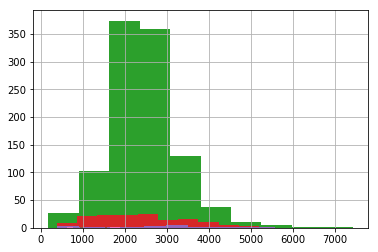

In [73]:
play[(np.abs(play["cost_diff"])>1)].groupby("cost_diff").Trip_Seconds.hist()

In [59]:
play.cost_diff.value_counts()

-0.0    45019
-1.0    12188
 1.0     1693
-2.0     1047
 2.0      151
-3.0       70
 3.0       24
-4.0       11
 5.0        3
 4.0        2
 7.0        1
Name: cost_diff, dtype: int64

In [69]:
play[(np.abs(play["cost_diff"])>3)]

,Trip_Start_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,distance_cat,cost_diff
23592,11,1767.0,16.5,41.899590,-87.674719,41.979071,-87.903040,6.0,5.0
39727,18,4137.0,19.7,41.979071,-87.903040,41.880994,-87.632746,7.0,-4.0
31969,13,3272.0,22.3,41.979071,-87.903040,42.004765,-87.659122,8.0,-4.0
58690,0,633.0,3.9,41.962179,-87.645379,41.907492,-87.635760,2.0,5.0
30743,12,1980.0,16.3,41.914586,-87.645966,41.979071,-87.903040,6.0,7.0
55629,6,1895.0,18.2,41.979071,-87.903040,41.899156,-87.626211,7.0,5.0
51513,0,2968.0,28.1,41.979071,-87.903040,41.970245,-87.713435,10.0,-4.0
57863,16,4390.0,40.0,41.979071,-87.903040,41.834097,-87.619290,10.0,-4.0
69399,8,935.0,8.3,41.892042,-87.631864,41.987226,-87.664938,3.0,4.0
81829,8,1585.0,13.7,41.901207,-87.676356,41.985015,-87.804532,5.0,4.0
